<a href="https://colab.research.google.com/github/westisle/Dense/blob/main/man_woman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ステップ1: 必要なライブラリの読み込み
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 日本語フォントの設定（グラフで日本語を表示するため）
plt.rcParams['font.family'] = 'DejaVu Sans'

# 乱数シードの設定（結果を再現可能にするため）
torch.manual_seed(42)
np.random.seed(42)

print("ライブラリの読み込みが完了しました！")
print(f"PyTorchのバージョン: {torch.__version__}")

ライブラリの読み込みが完了しました！
PyTorchのバージョン: 2.6.0+cu124


In [2]:
# ステップ1.5: Google Driveのマウント

from google.colab import drive

# Google Driveをマウント
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ステップ2: データの読み込み

import pandas as pd

# CSVファイルを読み込み
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2025_man_woman_metrics/data/man_woman_metrics.csv")

print("データを読み込みました！")
print(f"データの大きさ: {data.shape}")
print()

print("最初の5行:")
print(data.head())

データを読み込みました！
データの大きさ: (200, 5)

最初の5行:
            h          w          f          p  s
0  165.208511  56.838212  24.465345  32.566477  1
1  181.600202  76.549683  27.606623  34.155992  1
2  171.306928  67.956949  25.387608  33.559576  1
3  168.105110  67.901975  24.490529  31.658905  1
4  179.271522  78.330228  26.709178  31.935790  1


In [4]:
# ステップ3: データの基本確認

# 統計情報を表示
print("=== データの統計情報 ===")
print(data.describe())
print()

# 性別の分布を確認
print("=== 性別の分布 ===")
print(data['s'].value_counts())
print(f"男性(1): {(data['s'] == 1).sum()}人")
print(f"女性(0): {(data['s'] == 0).sum()}人")

=== データの統計情報 ===
                h           w           f           p           s
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean   165.116773   58.714489   24.443700   32.453851    0.500000
std      8.290756   10.289953    1.416132    1.605863    0.501255
min    145.911481   34.335583   21.071394   28.745508    0.000000
25%    158.319567   51.339561   23.283214   31.335250    0.000000
50%    165.626027   58.282687   24.354350   32.120604    0.500000
75%    170.965814   66.007735   25.533023   33.600050    1.000000
max    183.914982   89.926939   27.606623   37.776609    1.000000

=== 性別の分布 ===
s
1    100
0    100
Name: count, dtype: int64
男性(1): 100人
女性(0): 100人


In [5]:
# ステップ4: 先生のベースコードを準備

import torch
import torch.nn as nn
import numpy as np

# 先生から提供されたベースコード
def relu(x):
    x = torch.where(x > 0, x, torch.zeros_like(x))
    return x

def softmax(x):
    x -= torch.cat([x.max(axis=1, keepdim=True).values] * x.size()[1], dim=1)
    x_exp = torch.exp(x)
    return x_exp/torch.cat([x_exp.sum(dim=1, keepdim=True)] * x.size()[1], dim=1)

class Dense(nn.Module):  # nn.Moduleを継承する
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # He Initialization
        # in_dim: 入力の次元数、out_dim: 出力の次元数
        self.W = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(6/in_dim),
                        high=np.sqrt(6/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):  # forwardをoverride
        return self.function(torch.matmul(x, self.W) + self.b)

print("ベースコードの準備が完了しました！")
print("- relu関数")
print("- softmax関数")
print("- Dense層のクラス")

ベースコードの準備が完了しました！
- relu関数
- softmax関数
- Dense層のクラス


In [6]:
# ステップ5: データの前処理

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 特徴量（X）と目標変数（y）に分割
X = data[['h', 'w', 'f', 'p']].values  # 身長、体重、足長、骨盤幅
y = data['s'].values                   # 性別

print("=== データ分割前 ===")
print(f"特徴量Xの形状: {X.shape}")
print(f"目標変数yの形状: {y.shape}")
print(f"Xの最初の3行:\n{X[:3]}")
print(f"yの最初の5個: {y[:5]}")

# データを訓練用とテスト用に分割（8:2の比率）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n=== データ分割後 ===")
print(f"訓練用X: {X_train.shape}")
print(f"テスト用X: {X_test.shape}")
print(f"訓練用y: {y_train.shape}")
print(f"テスト用y: {y_test.shape}")

# 特徴量を標準化（平均0、標準偏差1に変換）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 訓練データで学習して変換
X_test_scaled = scaler.transform(X_test)        # テストデータは変換のみ

print("\n=== 標準化前後の比較 ===")
print("標準化前の訓練データ（最初の3行）:")
print(X_train[:3])
print("標準化後の訓練データ（最初の3行）:")
print(X_train_scaled[:3])

print(f"\n標準化後の平均: {X_train_scaled.mean(axis=0)}")
print(f"標準化後の標準偏差: {X_train_scaled.std(axis=0)}")

=== データ分割前 ===
特徴量Xの形状: (200, 4)
目標変数yの形状: (200,)
Xの最初の3行:
[[165.2085107   56.83821248  24.46534505  32.56647662]
 [181.6002016   76.54968267  27.60662251  34.15599212]
 [171.3069284   67.9569489   25.38760759  33.55957572]]
yの最初の5個: [1 1 1 1 1]

=== データ分割後 ===
訓練用X: (160, 4)
テスト用X: (40, 4)
訓練用y: (160,)
テスト用y: (40,)

=== 標準化前後の比較 ===
標準化前の訓練データ（最初の3行）:
[[174.0564102   56.6764049   24.76257944  34.98299451]
 [160.6908231   60.01150827  23.44701364  35.04518249]
 [177.1982239   75.27300523  26.20037999  31.27996116]]
標準化後の訓練データ（最初の3行）:
[[ 1.11972101 -0.22539109  0.24770799  1.61167139]
 [-0.53802075  0.10278197 -0.71835125  1.65077952]
 [ 1.50940204  1.60450817  1.30352786 -0.71705363]]

標準化後の平均: [1.12673759e-14 2.08860707e-15 3.13395143e-15 9.10452269e-15]
標準化後の標準偏差: [1. 1. 1. 1.]


In [7]:
# ステップ6: ニューラルネットワークモデルの定義

# 先生のDense層を使って全結合ニューラルネットワークを作成
class GenderPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 全結合層を積み重ねる
        # 入力: 4次元（身長、体重、足長、骨盤幅）
        self.layer1 = Dense(4, 16, relu)    # 4 → 16（活性化関数：ReLU）
        self.layer2 = Dense(16, 8, relu)    # 16 → 8（活性化関数：ReLU）
        self.layer3 = Dense(8, 2)           # 8 → 2（活性化関数なし）

    def forward(self, x):
        # 順伝播の処理
        x = self.layer1(x)    # 第1層
        x = self.layer2(x)    # 第2層
        x = self.layer3(x)    # 第3層（出力層）
        return x

# モデルを作成
model = GenderPredictionModel()

print("=== モデルの構造 ===")
print(model)
print()

# パラメータ数を確認
total_params = sum(p.numel() for p in model.parameters())
print(f"総パラメータ数: {total_params}")

# テスト入力で動作確認
test_input = torch.tensor([[1.0, 0.5, -0.2, 1.1]], dtype=torch.float32)
test_output = model(test_input)
print(f"\nテスト入力: {test_input}")
print(f"モデル出力: {test_output}")

# softmaxを適用して確率に変換
probabilities = softmax(test_output)
print(f"確率（softmax後）: {probabilities}")
print(f"女性の確率: {probabilities[0][0]:.3f}")
print(f"男性の確率: {probabilities[0][1]:.3f}")

=== モデルの構造 ===
GenderPredictionModel(
  (layer1): Dense()
  (layer2): Dense()
  (layer3): Dense()
)

総パラメータ数: 234

テスト入力: tensor([[ 1.0000,  0.5000, -0.2000,  1.1000]])
モデル出力: tensor([[ 0.0924, -0.5956]], grad_fn=<AddBackward0>)
確率（softmax後）: tensor([[0.6655, 0.3345]], grad_fn=<DivBackward0>)
女性の確率: 0.666
男性の確率: 0.334


In [8]:
# ステップ6.5: 損失関数と最適化アルゴリズムの定義（GPU対応）

import torch.optim as optim

# GPU/CPUの自動選択
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

# モデルをデバイスに移動
model = model.to(device)

# 損失関数：クロスエントロピー損失
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム：Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("=== 学習の準備完了 ===")
print(f"損失関数: {criterion}")
print(f"最適化アルゴリズム: {optimizer}")
print(f"学習率: 0.001")
print()

# データをPyTorchのTensorに変換してデバイスに移動
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

print("=== データのTensor変換完了 ===")
print(f"訓練用X: {X_train_tensor.shape}, データ型: {X_train_tensor.dtype}, デバイス: {X_train_tensor.device}")
print(f"訓練用y: {y_train_tensor.shape}, データ型: {y_train_tensor.dtype}, デバイス: {y_train_tensor.device}")
print(f"テスト用X: {X_test_tensor.shape}, データ型: {X_test_tensor.dtype}, デバイス: {X_test_tensor.device}")
print(f"テスト用y: {y_test_tensor.shape}, データ型: {y_test_tensor.dtype}, デバイス: {y_test_tensor.device}")
print()

# 損失関数のテスト
with torch.no_grad():  # 勾配計算を無効にして確認
    test_output = model(X_train_tensor[:5])  # 最初の5サンプル
    test_loss = criterion(test_output, y_train_tensor[:5])
    print(f"初期損失（5サンプル）: {test_loss:.4f}")

使用デバイス: cpu
=== 学習の準備完了 ===
損失関数: CrossEntropyLoss()
最適化アルゴリズム: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
学習率: 0.001

=== データのTensor変換完了 ===
訓練用X: torch.Size([160, 4]), データ型: torch.float32, デバイス: cpu
訓練用y: torch.Size([160]), データ型: torch.int64, デバイス: cpu
テスト用X: torch.Size([40, 4]), データ型: torch.float32, デバイス: cpu
テスト用y: torch.Size([40]), データ型: torch.int64, デバイス: cpu

初期損失（5サンプル）: 1.1233


In [9]:
# ステップ7: 学習ループの実行

# 学習の設定
num_epochs = 100  # 学習回数
train_losses = []  # 損失の記録用

print("=== 学習開始 ===")

for epoch in range(num_epochs):
    # 1. 順伝播（予測）
    outputs = model(X_train_tensor)

    # 2. 損失計算
    loss = criterion(outputs, y_train_tensor)

    # 3. 勾配をゼロにリセット
    optimizer.zero_grad()

    # 4. 逆伝播（勾配計算）
    loss.backward()

    # 5. パラメータ更新
    optimizer.step()

    # 損失を記録
    train_losses.append(loss.item())

    # 10エポックごとに進捗表示
    if (epoch + 1) % 10 == 0:
        print(f"エポック {epoch+1:3d}/{num_epochs}, 損失: {loss.item():.4f}")

print(f"\n学習完了！最終損失: {train_losses[-1]:.4f}")


=== 学習開始 ===
エポック  10/100, 損失: 0.6367
エポック  20/100, 損失: 0.5280
エポック  30/100, 損失: 0.4456
エポック  40/100, 損失: 0.3824
エポック  50/100, 損失: 0.3330
エポック  60/100, 損失: 0.2935
エポック  70/100, 損失: 0.2607
エポック  80/100, 損失: 0.2330
エポック  90/100, 損失: 0.2099
エポック 100/100, 損失: 0.1909

学習完了！最終損失: 0.1909


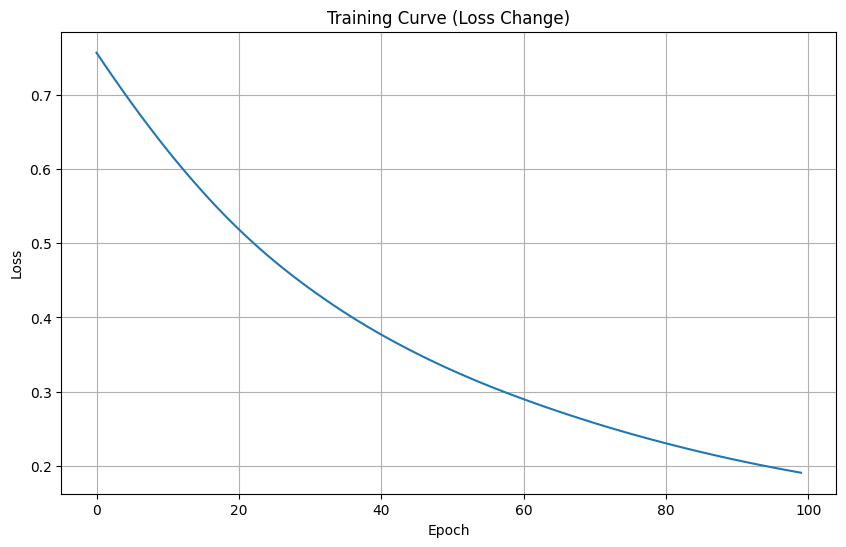

初期損失: 0.7563
最終損失: 0.1909
損失の改善: 0.5654


In [10]:
# ステップ7.5: 学習曲線をプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Curve (Loss Change)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f"初期損失: {train_losses[0]:.4f}")
print(f"最終損失: {train_losses[-1]:.4f}")
print(f"損失の改善: {train_losses[0] - train_losses[-1]:.4f}")

In [11]:
# ステップ8: モデルの評価とテスト（GPU対応）

import torch.nn.functional as F

# 評価モードに切り替え
model.eval()

with torch.no_grad():  # 勾配計算を無効化
    # 訓練データでの予測
    train_outputs = model(X_train_tensor)
    train_probabilities = F.softmax(train_outputs, dim=1)
    train_predictions = torch.argmax(train_probabilities, dim=1)

    # テストデータでの予測
    test_outputs = model(X_test_tensor)
    test_probabilities = F.softmax(test_outputs, dim=1)
    test_predictions = torch.argmax(test_probabilities, dim=1)

# 精度の計算
train_accuracy = (train_predictions == y_train_tensor).float().mean()
test_accuracy = (test_predictions == y_test_tensor).float().mean()

print("=== モデルの性能評価 ===")
print(f"訓練データの精度: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"テストデータの精度: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print()

# 詳細な結果表示
print("=== テストデータの予測結果（最初の10個） ===")
print("実際 | 予測 | 女性確率 | 男性確率")
print("-" * 40)

for i in range(10):
    actual = y_test_tensor[i].item()
    predicted = test_predictions[i].item()
    prob_female = test_probabilities[i][0].item()
    prob_male = test_probabilities[i][1].item()

    actual_label = "女性" if actual == 0 else "男性"
    predicted_label = "女性" if predicted == 0 else "男性"

    print(f"{actual_label:2s} | {predicted_label:2s} | {prob_female:.3f}   | {prob_male:.3f}")

# 混同行列の表示（CPUに移動してからnumpy変換）
from sklearn.metrics import confusion_matrix, classification_report

y_test_np = y_test_tensor.cpu().numpy()
test_predictions_np = test_predictions.cpu().numpy()

print("\n=== 混同行列 ===")
cm = confusion_matrix(y_test_np, test_predictions_np)
print("      予測")
print("     女性 男性")
print(f"実際 女性 {cm[0][0]:2d}  {cm[0][1]:2d}")
print(f"    男性 {cm[1][0]:2d}  {cm[1][1]:2d}")

print("\n=== 詳細レポート ===")
print(classification_report(y_test_np, test_predictions_np,
                          target_names=['女性', '男性']))

=== モデルの性能評価 ===
訓練データの精度: 0.9375 (93.75%)
テストデータの精度: 0.9500 (95.00%)

=== テストデータの予測結果（最初の10個） ===
実際 | 予測 | 女性確率 | 男性確率
----------------------------------------
男性 | 男性 | 0.048   | 0.952
男性 | 男性 | 0.316   | 0.684
男性 | 男性 | 0.163   | 0.837
女性 | 女性 | 0.995   | 0.005
女性 | 女性 | 1.000   | 0.000
女性 | 女性 | 0.987   | 0.013
男性 | 男性 | 0.366   | 0.634
女性 | 女性 | 0.994   | 0.006
女性 | 女性 | 0.981   | 0.019
男性 | 女性 | 0.802   | 0.198

=== 混同行列 ===
      予測
     女性 男性
実際 女性 18   1
    男性  1  20

=== 詳細レポート ===
              precision    recall  f1-score   support

          女性       0.95      0.95      0.95        19
          男性       0.95      0.95      0.95        21

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

